# Optimization

In this notebook, we explore how the scale of gradient of loss with respect to model parameters changes with layer in feed-forward neural network. It is found that the scale varies greatly between different layers, indicating that a proper optimization algorithm shall employ different learning-rates for different layers.

## Data and Model

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

tf.random.set_seed(1234)

Load and process MNIST dataset.

In [2]:
(ds_train,), ds_info = tfds.load(
    'mnist',
    split=['train'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

Define a feed-forward neural network with single hidden layer. This model is simple enough for a deeper analysis.

Explicitly, it is

$$ f^{\alpha}(x) := U^{\alpha}_{\beta} \sigma \left( W^{\beta}_{\gamma} x^{\gamma} + b^{\beta} \right) + c^{\alpha}. $$

In [3]:
def build_model(hidden_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hidden_dim, 'relu'),
        # tf.keras.layers.Dense(hidden_dim, 'relu'),  # test!
        tf.keras.layers.Dense(10),
    ])

    # Build the model
    x_batch = tf.random.uniform([128, 28, 28, 1])
    _ = model(x_batch)

    return model

Then define loss and functions for training.

In [4]:
def cross_entropy_loss(logits, labels):
    """Compute cross entropy loss with a sparse operation."""
    sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels)
    return tf.reduce_mean(sparse_ce)


def get_loss_and_grads(model, x_batch, y_batch):
    with tf.GradientTape() as tape:
        y_pred = model(x_batch)
        loss_batch = cross_entropy_loss(y_pred, y_batch)
    grads = tape.gradient(loss_batch, model.variables)
    return loss_batch, grads


def train_step(model, optimizer, x_batch, y_batch):
    loss_batch, grads = get_loss_and_grads(model, x_batch, y_batch)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss_batch

## Scales of Loss Gradients

We wonder how the $\partial L / \partial W$ and $\partial L / \partial U$ vary with training.

In [5]:
def loss_weight_grad_histogram(model, x_batch, y_batch):
    _, grads = get_loss_and_grads(model, x_batch, y_batch)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    grad_W, _, grad_U, _ = grads
    # grad_W, _, _, _, grad_U, _ = grads  # test!
    axs[0].hist(grad_W.numpy().reshape([-1]),
                bins=50, density=True, label='$\partial L / \partial W$')
    axs[0].legend()
    axs[0].tick_params(rotation=45)

    axs[1].hist(grad_U.numpy().reshape([-1]),
                bins=50, density=True, label='$\partial L / \partial U$')
    axs[1].legend()
    axs[1].tick_params(rotation=45)
    return fig

Let us train a model.

epoch = 0, loss = 0.18776164948940277
epoch = 1, loss = 0.12084954977035522
epoch = 2, loss = 0.08828000724315643
epoch = 3, loss = 0.06746280938386917
epoch = 4, loss = 0.05173899605870247


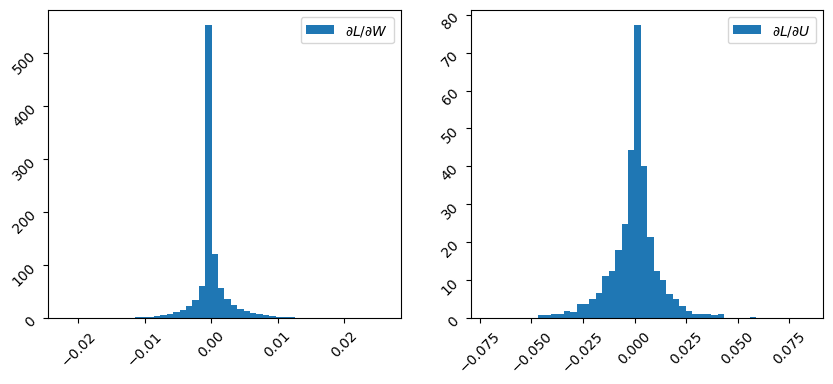

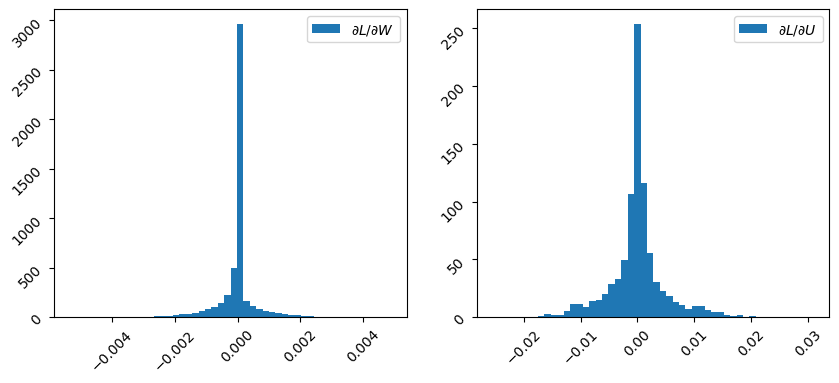

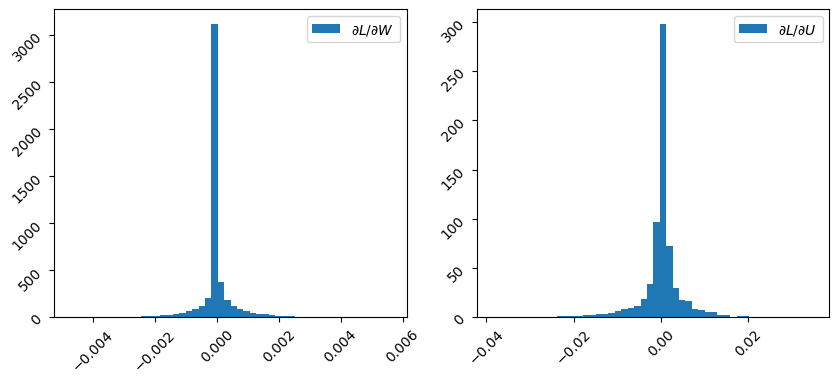

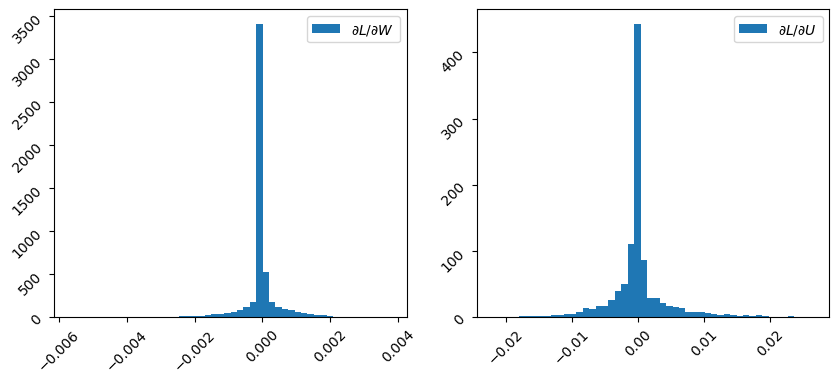

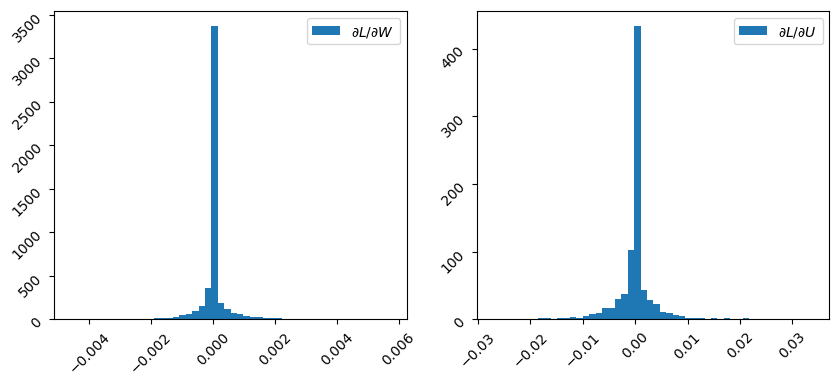

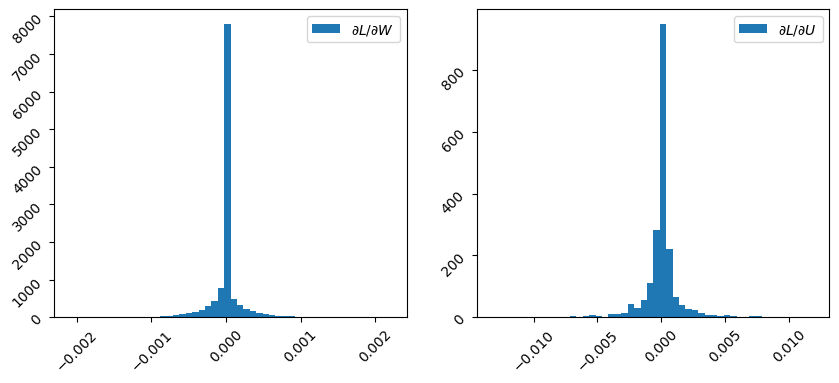

In [6]:
model = build_model(hidden_dim=256)
optimizer = tf.keras.optimizers.RMSprop(rho=0.9)

# Initializations.
loss_values = []
histograms = []
init_W, _, init_U, _ = [var.numpy() for var in model.variables]
# init_W, _, _, _, init_U, _ = [var.numpy() for var in model.variables]  # test!

# Training process.
for epoch in range(5):
    ds_iter = ds_train.as_numpy_iterator()
    x_batch, y_batch = next(ds_iter)
    histograms.append(loss_weight_grad_histogram(model, x_batch, y_batch))

    while True:
        loss_batch = train_step(model, optimizer, x_batch, y_batch)
        loss_values.append(loss_batch.numpy())
        try:
            x_batch, y_batch = next(ds_iter)
        except StopIteration:
            break
    print(f'epoch = {epoch}, loss = {np.mean(loss_values[-200:])}')

histograms.append(loss_weight_grad_histogram(model, x_batch, y_batch))

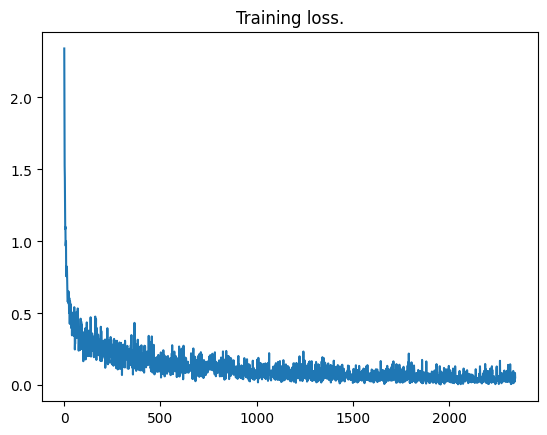

In [7]:
plt.plot(loss_values)
plt.title('Training loss.')
plt.show()

From the histograms plotted in different epochs, we find that $\| \partial L / \partial U \| \gg \| \partial L / \partial W \|$. (This is also true for deeper feed-forward neural network.) But the total difference between the initial and final (after training) values of $U$ and that of $W$ share the same order!

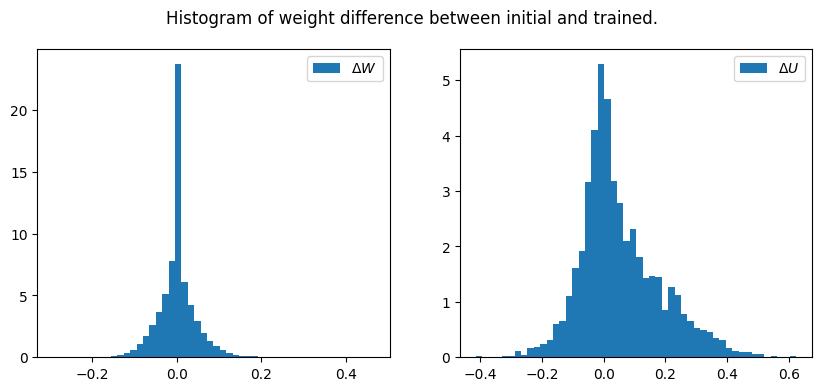

In [8]:
post_W, _, post_U, _ = [var.numpy() for var in model.variables]
# post_W, _, _, _, post_U, _ = [var.numpy() for var in model.variables]  # test!

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist((init_W - post_W).reshape([-1]),
            bins=50, density=True, label='$\Delta W$')
axs[0].legend()

U_idx = -2
axs[1].hist((init_U - post_U).reshape([-1]),
            bins=50, density=True, label='$\Delta U$')
axs[1].legend()

fig.suptitle('Histogram of weight difference between initial and trained.')
plt.show()

This indicates that the optimization of $U$ will be much faster than that of $W$. And $U$ has to wait for $W$ to be optimized, leading to a prolonged training process. **This indicates that the learning-rate for the parameters of different layers shall be different. It should be scaled by a factor proprotional to $1 / \| \partial L / \partial \theta_l \|$ where $\theta_l$ represents the parameters of layer $l$.**

## Test by Creating an Optimizer

Based on this understanding, we implement an optimizer which assigns different learning-rates for different parameters. The basic idea is the same as the [RMSProp algorithm](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp), but the adaptation of learning-rate is layer-wise instead of element-wise. We find that this optimizer performs as good as `RMSprop`, with much less memory occupition.

In [9]:
class MyOptimizer(tf.Module):
    """Layer-wise self-adaptive learning rate.

    Args:
        learning_rate: Initial learning-rate.
        rho: Discounting factor for the old gradients.
        epsilon: A small constant for numerical stability.
    """

    def __init__(self, learning_rate=1e-3, rho=0.9, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.rho = rho
        self.epsilon = epsilon

        self.rms_vars = []
        self.built = False

    def apply_gradients(self, grads_and_vars):
        grads_and_vars = list(grads_and_vars)

        # Build the optimizer if `self.build` is `False`.
        if not self.built:
            for _, var in grads_and_vars:
                # Comparing with RMSprop, the initialized RMS variables are
                # initialized to 1 (rather than 0).
                self.rms_vars.append(tf.Variable(1, dtype='float32'))
            self.built = True

        for i, (grad, var) in enumerate(grads_and_vars):
            # Update RMS variables.
            new_rms = tf.reduce_mean(tf.square(grad))
            self.rms_vars[i] = (
                self.rho * self.rms_vars[i]  # memorization of the old RMS value.
                + (1-self.rho) * new_rms  # acceptance of the new RMS value.
            )
            # The scaled learning-rate.
            scaled_learning_rate = self.learning_rate / (tf.sqrt(self.rms_vars[i]) + self.epsilon)
            # Update trainable parameter.
            var.assign_sub(scaled_learning_rate * grad)

Train the model with the same hyper-parameters, but now by `MyOptimizer`.

epoch = 0, loss = 0.23709136247634888
epoch = 1, loss = 0.12402942031621933
epoch = 2, loss = 0.09125076979398727
epoch = 3, loss = 0.06774868071079254
epoch = 4, loss = 0.05617354437708855
Final loss = 0.05617354437708855


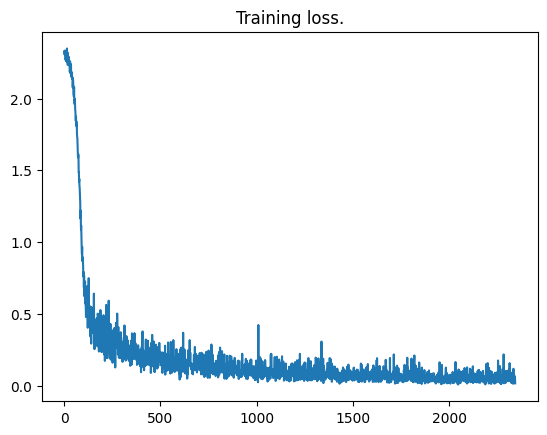

In [10]:
model = build_model(hidden_dim=256)
optimizer = MyOptimizer(rho=0.9)

# Initializations.
loss_values = []

# Training process.
for epoch in range(5):
    ds_iter = ds_train.as_numpy_iterator()
    while True:
        try:
            x_batch, y_batch = next(ds_iter)
        except StopIteration:
            break
        loss_batch = train_step(model, optimizer, x_batch, y_batch)
        loss_values.append(loss_batch.numpy())
    print(f'epoch = {epoch}, loss = {np.mean(loss_values[-200:])}')

print(f'Final loss = {np.mean(loss_values[-200:])}')

plt.plot(loss_values)
plt.title('Training loss.')
plt.show()

The initial hesitation is caused by the RMS initialization which is 1 for `MyOptimizer` but 0 for `RMSprop`. This leads to a little higher final loss comparing with `RMSprop`. The final performance of `MyOptimizer` is comparable with that of `RMSprop`, indicating that **layer-wise learning-rate adaptation is the key of RMSProp algorithm and its variations.**